### Arjun Prakash
#### 21239525
#### MSc. AI

## CT5141 Optimisation Assignment 2 (James McDermott)



**Topic** Facility location with real-valued metaheuristic optimisation. How to run experiments.

**Problem** The **facility location** problem is about finding the best locations for some facilities. In our problem, we have a list of cities, and we are going to build some supermarkets to serve the customers in these cities. The supermarkets could be anywhere, not just at the cities, i.e. a supermarket could be near a city or between two cities. There is no population outside the cities. Supermarkets have no limit on capacity. We want to locate the supermarkets so as to minimise the total travel time for all customers. The objective function is formulated in `supermarket.ipynb` with data in `supermarket_cities_locations.csv` and `supermarket_cities_populations.csv`. A plotting function is included. We will implement a Random Search approach to this problem, a Particle Swarm Optimisation approach, and a CMA approach.


In [1]:
#Import all the required libraries
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pyswarms as ps
from itertools import product
import cma
import time as t
import pandas as pd


In [2]:
def total_travel_time(x, c, p):
    # x: locations of supermarkets (ie genotype), shape eg (5, 2)
    # c: locations of cities, shape eg (20, 2)
    # p: populations of cities, shape eg (20,)

    # assume that everyone travels to the supermarket exactly once per
    # week

    # assume that travel time is exactly proportional to Euclidean
    # distance from city to supermarket
    
    # calculate all city-supermarket distances. with (eg) 20 cities
    # and 5 supermarkets, we'll have d.shape = (20, 5)
    d = cdist(c, x)
    # everyone in city i will travel to their nearest supermarket,
    # so we need minimum distance from each city to any supermarket.
    dmin = np.min(d, axis=1)
    # there are p[i] people in city i, each travelling a distance
    # dmin[i], so multiply and sum for total travel time
    return np.sum(dmin * p)

def total_travel_time_slow(x, c, p):
    # Notice that the above is vectorised and is only 2-3 lines. 
    # it's equivalent to this slower (easier to understand?) code
    d = cdist(c, x)
    t = 0
    for i, pi in enumerate(p):
        # everyone in city i will travel to their nearest supermarket,
        # so we need minimum distance from city i to any supermarket.
        d = np.min(D[i])
        # there are pi people in city i, each travelling a distance d
        t += pi * d 
    return t


def plot(x, c, p):
    # solutions will be of shape (eg) (10,)
    # but we interpret as shape (5, 2)
    x = x.reshape((-1, 2))
    plt.figure(figsize=(6, 5))
    plt.scatter(c[:, 0], c[:, 1], s=p/10000, label="Cities") # s gives size
    plt.scatter(x[:, 0], x[:, 1], marker="*", label="Supermarkets") # stars for supermarkets
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.savefig("supermarket.pdf")
    plt.show()
    plt.close()


In [3]:
c = np.genfromtxt("supermarket_city_locations.csv")
p = np.genfromtxt("supermarket_city_populations.csv")
ncities = len(c)
nsupermarkets = 5

In [4]:
# common parameters
maxits = 20000
reps = 5
newbestarr=0
dimension = 2
particles=100

In [5]:
# function for computing loss for ps.single.GlobalBestPSO()
def compute_loss(x):
    loss=[]
    x=np.array(x).reshape(popsize,nsupermarkets,dimension) #Reshape the data according to total_travel_time input shape
    for i in x:
        loss.append(total_travel_time(i,c,p))
    return loss       # Return loss in list of length popsize

In [6]:
# Calculating time by finding difference between each timestamp
def process_time(data):
    for i in range(len(data)-1):
        data[i]=data[i+1]-data[i]
    data.pop(-1)
    return data  #Return calculated time

In [7]:
#Variables to store cost, output of Randomsearch for every repetitions
def rsrun():
    global rscost,rsdata,rstime
    rscost=[]
    rsdata=[]
    rstime=[]
    #Calculate time
    rstime.append(t.time())  

    #RandomSearch Implementation
    def randomsearch(b,cb):
        for i in range(maxits):
            t=total_travel_time(b,c,p)
            if t<cb:
                newbestarr=b
                cb=t
            b=np.random.rand(nsupermarkets,dimension)
        return cb,newbestarr

    for i in range(reps):
        np.random.seed(i) # Seed from 0-4
        temp=np.random.rand(nsupermarkets,dimension)

        #Store best cost and optimal output
        cbest,b=randomsearch(temp,total_travel_time(np.random.rand(nsupermarkets,dimension),c,p))
        rsdata.append(b)
        rscost.append(cbest)
        rstime.append(t.time())
    #Calculatet time
    rstime=process_time(rstime)


In [8]:
def psorun():
    global psodata,psocost,psotime,popsize,psoc1,psoc2,psow,psopop,psomin,psomean,psostd
    psodata=[]
    psocost=[]
    psotime=[]
    popsize=0

    # Combinations of w,c1,c2,popsize parameter
    global permutation
    
    """
    Setting w value to make the algorithm explorative/exploitative. Low velocity (w) makes the algorithm eploitative
    and large value makes it explorative. So I have chosen small and large value combination for w (Third parameter).
    
    C1 and C2 are parameter for Personal best and global best. Higher value of C1 will have high influence on the particle towards
    its own personal best (High confidence on its own Personal best). High value of C2 will influence the particle 
    towards the global best (High confidence on the global best). So I have chosen  high and low value for both the parameters 
    to understand the converging behaviour. 
    
    Increasing population size increases the chances of of finding the optima soon.
    So have chosen the second value of population size as 1.5X times the first one.
    
    """
    permutation=list(product([0.2,0.7],[0.4,0.8],[0.25,0.75],[100,150]))
    psotime.append(t.time())
    for j in range(len(permutation)):
        #Initialize options and bounds
        options = {'c1': permutation[j][0], 'c2': permutation[j][1], 'w':permutation[j][2]}  #c1=pbest,c2=gbest
        bound=np.zeros(nsupermarkets*dimension),np.ones(nsupermarkets*dimension)
        for i in range(reps):
            #set seed
            np.random.seed(i)
            popsize=permutation[j][3]
            #Set optimizer object
            optimizer = ps.single.GlobalBestPSO(n_particles=popsize, dimensions=nsupermarkets*dimension, options=options,bounds=bound)
            #Store cost and optimal values
            cost, pos = optimizer.optimize(compute_loss, iters=maxits//popsize)
            psodata.append(pos)
            psocost.append(cost)
            psotime.append(t.time())
    psotime=process_time(psotime)
    
    #Computing the min,mean,stddiv of the PSO
    lis=np.array(psocost)
    lis=lis.reshape(len(permutation),reps)
    psomin=np.round(np.min(lis,axis=1))
    psomean=np.round(np.mean(lis,axis=1))
    psostd=np.round(np.std(lis,axis=1))
    psotime=np.mean(np.array(psotime).reshape(len(permutation),reps),axis=1)
    psoc1,psoc2,psow,psopop=np.array(permutation).T

In [9]:
def cmarun():
    global cmadata
    cmadata=[]
    global cmacost
    cmacost=[]
    history = []
    global cmatime
    cmatime=[]
    #log the start time
    cmatime.append(t.time())

    for i in range(reps):
        sigma = 0.5
        seed=i+1
        #Initialize CMA 
        es = cma.CMAEvolutionStrategy(np.random.rand(nsupermarkets*dimension),sigma,{'bounds': [0.0, 1.0],'seed': seed})
        i = 0
        # Compute till saturation or till maxiteration
        while not es.stop() and i<maxits:
            X = es.ask()
            if i % 10 == 0:
                current_x = X[0] 
                history.append(current_x)  #Store in history
            es.tell(X, [total_travel_time(x.reshape(nsupermarkets,dimension),c,p) for x in X])
            es.disp()
            i += 1
        # Store the result data
        xbest, fbest, evals_best, evaluations, iterations, xfavorite, stds, stop = es.result
        cmadata.append(xbest)
        cmacost.append(fbest)
        cmatime.append(t.time())
    #Computer time
    cmatime= process_time(cmatime)

In [10]:
rsrun()
psorun()
cmarun()
np.array(psocost).reshape(16,5)[0]

2021-11-21 21:09:07,727 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.2, 'c2': 0.4, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=3.57e+5
2021-11-21 21:09:08,570 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 357182.87038936466, best pos: [0.6452223  0.40290148 0.809439   0.76814844 0.72309389 0.67825567
 0.42513729 0.51065426 0.28114677 0.43468803]
2021-11-21 21:09:08,575 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.2, 'c2': 0.4, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.81e+5
2021-11-21 21:09:09,455 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 281463.93486730667, best pos: [0.82369941 0.78340754 0.53678825 0.54460875 0.2676828  0.50038128
 0.56044906 0.61562706 0.64822621 0.4024041 ]
2021-11-21 21:09:09,461 - py

2021-11-21 21:09:21,601 - pyswarms.single.global_best - INFO - Optimize for 133 iters with {'c1': 0.2, 'c2': 0.4, 'w': 0.75}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|133/133, best_cost=2.58e+5
2021-11-21 21:09:22,374 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 258493.30559638632, best pos: [0.41292753 0.23644944 0.54315629 0.52991348 0.6483182  0.40237893
 0.33530827 0.76399786 0.80953864 0.76830096]
2021-11-21 21:09:22,380 - pyswarms.single.global_best - INFO - Optimize for 133 iters with {'c1': 0.2, 'c2': 0.4, 'w': 0.75}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|133/133, best_cost=2.24e+5
2021-11-21 21:09:23,095 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 224055.3754094879, best pos: [0.3412031  0.43194573 0.54259908 0.52992579 0.64831791 0.4023767
 0.80954197 0.7682962  0.11017952 0.55382227]
2021-11-21 21:09:23,100 - pysw

2021-11-21 21:09:35,107 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.2, 'c2': 0.8, 'w': 0.75}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|200/200, best_cost=1.9e+5
2021-11-21 21:09:35,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 189986.29982024748, best pos: [0.81090105 0.76666289 0.10580634 0.33137545 0.64710595 0.40356638
 0.88142095 0.9870383  0.56360437 0.53443347]
2021-11-21 21:09:35,916 - pyswarms.single.global_best - INFO - Optimize for 133 iters with {'c1': 0.2, 'c2': 0.8, 'w': 0.75}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|133/133, best_cost=2.23e+5
2021-11-21 21:09:36,632 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 222768.57242295606, best pos: [0.81164108 0.77009575 0.64999902 0.4032392  0.11441673 0.45962437
 0.54712873 0.52043149 0.38360857 0.961229  ]
2021-11-21 21:09:36,639 - py

2021-11-21 21:09:48,179 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.7, 'c2': 0.4, 'w': 0.75}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.11e+5
2021-11-21 21:09:49,071 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 210890.55057489977, best pos: [0.80954198 0.76829618 0.10161828 0.55708676 0.48993311 0.13879566
 0.64831793 0.4023767  0.54259912 0.52992777]
2021-11-21 21:09:49,078 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.7, 'c2': 0.4, 'w': 0.75}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=1.75e+5
2021-11-21 21:09:49,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 175322.26581321502, best pos: [0.09439334 0.35725823 0.11861515 0.66697137 0.54266399 0.52993369
 0.80954433 0.76830572 0.64831797 0.40237638]
2021-11-21 21:09:49,897 - py

2021-11-21 21:10:01,986 - pyswarms.single.global_best - INFO - Optimize for 133 iters with {'c1': 0.7, 'c2': 0.8, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|133/133, best_cost=2.55e+5
2021-11-21 21:10:02,708 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 254538.7296833834, best pos: [0.54260674 0.52993348 0.81306685 0.78083646 0.23403389 0.50809361
 0.81253496 0.72547981 0.64831823 0.40237684]
2021-11-21 21:10:02,714 - pyswarms.single.global_best - INFO - Optimize for 133 iters with {'c1': 0.7, 'c2': 0.8, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|133/133, best_cost=2.07e+5
2021-11-21 21:10:03,409 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 207212.76273706838, best pos: [0.54230545 0.52991291 0.80968513 0.76811538 0.20447352 0.70943975
 0.64832483 0.40238279 0.20257511 0.45920946]
2021-11-21 21:10:03,414 - pys

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1, Sun Nov 21 21:10:11 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 5.374737890245706e+05 1.0e+00 4.63e-01  4e-01  5e-01 0:00.0
    2     20 7.830421432042529e+05 1.2e+00 4.59e-01  4e-01  5e-01 0:00.0
    3     30 5.211370912357515e+05 1.3e+00 4.48e-01  4e-01  5e-01 0:00.0
  100   1000 7.797091863706501e+05 7.0e+00 1.40e+00  1e+00  2e+00 0:00.2
  200   2000 1.008746448986757e+06 2.0e+01 4.64e+00  3e+00  7e+00 0:00.4
  300   3000 7.232206241684048e+05 2.9e+01 6.42e+00  5e+00  7e+00 0:00.6
  400   4000 1.013404327864947e+06 3.3e+01 3.20e+00  2e+00  3e+00 0:00.8
  500   5000 1.013902995598866e+06 6.7e+01 4.81e+00  2e+00  4e+00 0:01.0
  600   6000 7.365512650694291e+05 5.4e+01 2.78e+00  9e-01  2e+00 0:01.2
  700   7000 9.452603523114081e+05 1.3e+02 4.18e+00  1e+00  4e+00 0:01.4
  800   8000 7.280362847469869e+05 3.2e+02 2.54e+01  8e+00  2e+01 0:01.5
  900   9000 6.856427934736285e+05 6.3

array([357182.87038936, 281463.93486731, 406268.20694812, 341452.48733935,
       292119.60660064])

## Output Table

In [11]:
cols=["Algorithms","popsize","w","cg","cp","min","mean","stddiv","time"]
df=pd.DataFrame(columns=cols)

In [12]:
df=df.append({"Algorithms":"RandomSearch",
              "popsize":"NA",
              "w":"NA",
              "cg":"NA",
              "cp":"NA",
              "min":int(min(rscost)),
              "mean":int(np.mean(rscost)),
              "stddiv":int(np.std(rscost)),
              "time":np.mean(rstime)},
             ignore_index=True)
df=df.append({"Algorithms":"CMA",
              "popsize":"NA",
              "w":"NA",
              "cp":"NA",
              "cg":"NA",
              "min":int(min(cmacost)),
              "mean":int(np.mean(cmacost)),
              "stddiv":int(np.std(cmacost)),
              "time":np.mean(cmatime)},
             ignore_index=True)
psoc1,psoc2,psow,psopop=np.array(permutation).T
td={"Algorithms":["PSO" for i in range(len(psotime))],
           "popsize":list(psopop),
           "w":list(psow),
           "cg":list(psoc1),
           "cp":list(psoc2),
           "min":list(psomin),
           "mean":list(psomean),
           "stddiv":list(psostd),
           "time":list(psotime)}

table=pd.concat([df,pd.DataFrame(td)])
print(table)

      Algorithms popsize     w   cg   cp     min    mean stddiv      time
0   RandomSearch      NA    NA   NA   NA  304751  364586  31966  0.500290
1            CMA      NA    NA   NA   NA  150284  216503  99304  1.631538
0            PSO     100  0.25  0.2  0.4  281464  335697  45421  0.854181
1            PSO     150  0.25  0.2  0.4  296096  313768  18951  0.737156
2            PSO     100  0.75  0.2  0.4  157349  203184  30268  0.878955
3            PSO     150  0.75  0.2  0.4  151054  201984  37908  0.752729
4            PSO     100  0.25  0.2  0.8  233706  274113  35179  0.820278
5            PSO     150  0.25  0.2  0.8  211878  280462  55487  0.738175
6            PSO     100  0.75  0.2  0.8  173798  201991  19515  0.856359
7            PSO     150  0.75  0.2  0.8  188732  203830  12863  0.724704
8            PSO     100  0.25  0.7  0.4  258959  284629  21132  0.823567
9            PSO     150  0.25  0.7  0.4  237357  271585  31539  0.737655
10           PSO     100  0.75  0.7  0

In [39]:
table[table['min'] == table['min'].min()]

,Algorithms,popsize,w,cg,cp,min,mean,stddiv,time
1,CMA,NA,NA,NA,NA,150284,216503,99304,1.631538


In [13]:
#For plotting the best values from all the data
def plot_best():
    global cst,mindata,ind
    mindata=[cmacost,psocost,rscost]
    cst=[cmadata,psodata,rsdata]
    minind=[np.min(i) for i in mindata].index(np.min([np.min(i) for i in mindata]))
    ind=mindata[minind].index(np.min(mindata[minind]))
    plot(cst[minind][ind].reshape(5,2),c,p)
    print("Optimal value for location:\n",cst[minind][ind].reshape(5,2))
    print("\nCost:",round(total_travel_time(cst[minind][ind].reshape(5,2),c,p)))

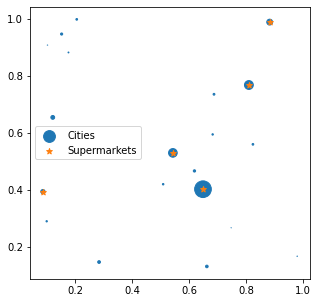

Optimal value for location:
 [[0.5425991  0.52992577]
 [0.88256928 0.98920928]
 [0.08617522 0.39393245]
 [0.80954198 0.76829616]
 [0.64831793 0.4023767 ]]

Cost: 150284


In [14]:
plot_best()

## Report

#### Modules Installed:

pip install pyswarms

pip install cma


### Algorithm Comparison
Out of all the algorithms, CMA had the lowest cost followed by PSO giving almost close minimum cost. RS algorithm doesn't guarantee consistent results. 
Random search had the highest cost of 304751.
##### Hyperparameters in PSO
For all the permutations of hyperparameters, the cost was comparitively higher when the velocity (w) was less(0.25, exploitative). This is because it takes more time for the swarms to converge with slow velocity. When the velocity is high, the mean cost is low. Also, when the popsize(number of swarms) is high, it takes less time to find the global value. 
When the velocity, cp,cg parameter along with the pop size is maximised, the standard diviation and mean are less i.e., the swarms are quickly converging towards the best possible minima.
##### CMA 
CMA algorithm gave the best cost value. The algorithmduring every iteration, discards the bad values with respect to cost and uses the good values for crossover to generate more children around the best optimum region. So with every iteration, the new generated values are always better than the old ones. CMA took more time for each repetition whereas the Random Search algorithm took the least time.


Reference:
https://pyswarms.readthedocs.io/en/latest/